# 02. Building GPT Block - Transformer의 기본 단위

이 노트북에서는 GPT의 기본 빌딩 블록인 **Transformer Block**을 구성합니다.

## 구성 요소
1. Multi-Head Attention
2. Feed-Forward Network
3. Layer Normalization
4. Residual Connections

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

## 1. Layer Normalization

**왜 필요한가?**
- 깊은 네트워크에서 gradient 안정화
- 학습 속도 향상
- Internal covariate shift 감소

In [10]:
# Layer Norm 이해하기
B, T, C = 2, 4, 8  # batch, sequence, embedding
x = torch.randn(B, T, C)

print("x: ", x.shape)

# 수동으로 Layer Norm 계산
mean = x.mean(dim=-1, keepdim=True)  # 각 토큰의 평균

std = x.std(dim=-1, keepdim=True)    # 각 토큰의 표준편차
x_norm_manual = (x - mean) / (std + 1e-5)

print("x_norm_manual: ", x_norm_manual.shape)

print(f"원본 통계:")
print(f"  평균: {x[0, 0].mean():.4f}")
print(f"  표준편차: {x[0, 0].std():.4f}")

print(f"\nNormalized 통계:")
print(f"  평균: {x_norm_manual[0, 0].mean():.4f} (≈0)")
print(f"  표준편차: {x_norm_manual[0, 0].std():.4f} (≈1)")

# PyTorch Layer Norm
layer_norm = nn.LayerNorm(C)
x_norm_pytorch = layer_norm(x)

print(f"\nPyTorch LayerNorm도 동일한 결과:")
print(f"  평균: {x_norm_pytorch[0, 0].mean():.4f}")
print(f"  표준편차: {x_norm_pytorch[0, 0].std():.4f}")

x:  torch.Size([2, 4, 8])
x_norm_manual:  torch.Size([2, 4, 8])
원본 통계:
  평균: -0.1967
  표준편차: 0.9060

Normalized 통계:
  평균: -0.0000 (≈0)
  표준편차: 1.0000 (≈1)

PyTorch LayerNorm도 동일한 결과:
  평균: -0.0000
  표준편차: 1.0690


## 2. Feed-Forward Network (FFN)

**구조**: Linear → ReLU → Linear

**왜 필요한가?**
- Attention은 토큰 간 관계만 학습
- FFN은 각 위치에서 독립적으로 특징 변환
- 보통 4배 확장 후 축소 (bottleneck)

In [11]:
class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # 확장
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # 축소
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)

# 테스트
n_embd = 64
ffn = FeedForward(n_embd)
x = torch.randn(1, 10, n_embd)  # (batch, seq_len, embedding)
out = ffn(x)

print(f"입력: {x.shape}")
print(f"출력: {out.shape}")
print(f"\n중간 차원: {n_embd} → {4*n_embd} → {n_embd}")
print("FFN은 각 위치에서 독립적으로 작동")

입력: torch.Size([1, 10, 64])
출력: torch.Size([1, 10, 64])

중간 차원: 64 → 256 → 64
FFN은 각 위치에서 독립적으로 작동


## 3. Residual Connection

**x + f(x)** 형태로 입력을 출력에 더함

**왜 중요한가?**
- Gradient vanishing 문제 해결
- 깊은 네트워크 학습 가능
- 정보 손실 방지

In [12]:
# Residual connection 시각화
x = torch.randn(1, 4, 8)
transform = nn.Linear(8, 8)

# Without residual
y_no_residual = transform(x)

# With residual
y_with_residual = x + transform(x)

# 비교
print("Gradient flow:")
print("- Without residual: gradient는 transform을 통과해야 함")
print("- With residual: gradient가 직접 전달되는 경로 존재 (+)")
print("\n정보 보존:")
print(f"- 원본 정보 norm: {x.norm():.4f}")
print(f"- Without residual norm: {y_no_residual.norm():.4f}")
print(f"- With residual norm: {y_with_residual.norm():.4f} (원본 정보 보존)")

Gradient flow:
- Without residual: gradient는 transform을 통과해야 함
- With residual: gradient가 직접 전달되는 경로 존재 (+)

정보 보존:
- 원본 정보 norm: 6.7622
- Without residual norm: 3.9294
- With residual norm: 8.2923 (원본 정보 보존)


## 4. 완전한 Transformer Block 구성

구성:
1. Multi-Head Attention + Residual + LayerNorm
2. Feed-Forward + Residual + LayerNorm

In [13]:
# 먼저 간단한 Attention Head
class Head(nn.Module):
    def __init__(self, head_size, n_embd, block_size, dropout=0.1):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # Attention
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        # Output
        v = self.value(x)
        out = wei @ v
        return out

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout=0.1):
        super().__init__()
        self.heads = nn.ModuleList([
            Head(head_size, n_embd, block_size, dropout) 
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [14]:
# 완전한 Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        super().__init__()
        head_size = n_embd // n_head
        
        # Multi-Head Attention
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        
        # Feed-Forward
        self.ffwd = FeedForward(n_embd, dropout)
        
        # Layer Norms
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        # Attention + Residual + LayerNorm
        x = x + self.sa(self.ln1(x))
        
        # FFN + Residual + LayerNorm  
        x = x + self.ffwd(self.ln2(x))
        
        return x

# 테스트
block = TransformerBlock(n_embd=64, n_head=4, block_size=32)
x = torch.randn(2, 10, 64)  # (batch, seq, embd)
out = block(x)

print(f"Transformer Block:")
print(f"  입력: {x.shape}")
print(f"  출력: {out.shape}")
print(f"\n구성:")
print(f"  - 4개의 attention head")
print(f"  - 각 head size: 16")
print(f"  - FFN 확장: 64 → 256 → 64")

Transformer Block:
  입력: torch.Size([2, 10, 64])
  출력: torch.Size([2, 10, 64])

구성:
  - 4개의 attention head
  - 각 head size: 16
  - FFN 확장: 64 → 256 → 64


## 5. 여러 Block 쌓기 - Deep GPT

GPT는 여러 Transformer Block을 쌓아서 만듦:
- GPT-1: 12 blocks
- GPT-2: 48 blocks
- GPT-3: 96 blocks

In [15]:
# 간단한 GPT 모델
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer):
        super().__init__()
        # Token + Position embeddings
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        
        # Transformer blocks
        self.blocks = nn.Sequential(*[
            TransformerBlock(n_embd, n_head, block_size) 
            for _ in range(n_layer)
        ])
        
        # Final layer norm
        self.ln_f = nn.LayerNorm(n_embd)
        
        # Output projection
        self.lm_head = nn.Linear(n_embd, vocab_size)
    
    def forward(self, idx):
        B, T = idx.shape
        
        # Embeddings
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(torch.arange(T))
        x = tok_emb + pos_emb
        
        # Transformer blocks
        x = self.blocks(x)
        x = self.ln_f(x)
        
        # Output
        logits = self.lm_head(x)
        return logits

# 작은 모델 생성
model = MiniGPT(
    vocab_size=100,
    n_embd=64,
    block_size=32,
    n_head=4,
    n_layer=4  # 4개 block
)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
print(f"MiniGPT 모델:")
print(f"  총 파라미터: {total_params:,}")
print(f"  Transformer blocks: 4")
print(f"  Attention heads per block: 4")
print(f"  Embedding dimension: 64")

MiniGPT 모델:
  총 파라미터: 214,244
  Transformer blocks: 4
  Attention heads per block: 4
  Embedding dimension: 64


## 6. Block의 정보 흐름 시각화

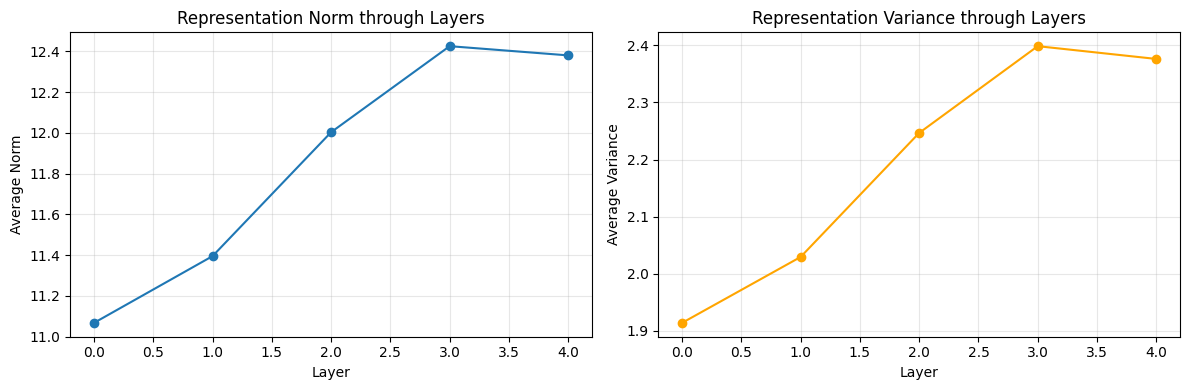

관찰:
- Residual connection 덕분에 norm이 안정적
- Layer Norm이 variance를 조절
- 깊은 네트워크에서도 gradient 전달 가능


In [16]:
# 각 block을 통과하며 표현이 어떻게 변하는지
def visualize_block_progression(model, input_ids):
    with torch.no_grad():
        # Initial embeddings
        B, T = input_ids.shape
        tok_emb = model.token_embedding(input_ids)
        pos_emb = model.position_embedding(torch.arange(T))
        x = tok_emb + pos_emb
        
        representations = [x]
        
        # Track through each block
        for i, block in enumerate(model.blocks):
            x = block(x)
            representations.append(x)
    
    return representations

# 테스트 입력
input_ids = torch.randint(0, 100, (1, 8))  # 8 tokens
reps = visualize_block_progression(model, input_ids)

# 각 레이어의 representation norm
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Norm progression
norms = [rep[0].norm(dim=-1).mean().item() for rep in reps]
axes[0].plot(norms, 'o-')
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Average Norm')
axes[0].set_title('Representation Norm through Layers')
axes[0].grid(True, alpha=0.3)

# Variance progression
vars = [rep[0].var(dim=-1).mean().item() for rep in reps]
axes[1].plot(vars, 'o-', color='orange')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Average Variance')
axes[1].set_title('Representation Variance through Layers')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("관찰:")
print("- Residual connection 덕분에 norm이 안정적")
print("- Layer Norm이 variance를 조절")
print("- 깊은 네트워크에서도 gradient 전달 가능")

## 7. Pre-LN vs Post-LN Architecture

GPT는 **Pre-LN** 사용: LayerNorm을 attention/FFN 전에 적용

In [17]:
class PostLNBlock(nn.Module):
    """Post-LN: 원래 Transformer 논문 스타일"""
    def forward(self, x):
        # x → Attention → Add → LN
        x = self.ln1(x + self.attention(x))
        # x → FFN → Add → LN
        x = self.ln2(x + self.ffn(x))
        return x

class PreLNBlock(nn.Module):
    """Pre-LN: GPT 스타일 (더 안정적)"""
    def forward(self, x):
        # x → LN → Attention → Add
        x = x + self.attention(self.ln1(x))
        # x → LN → FFN → Add
        x = x + self.ffn(self.ln2(x))
        return x

print("Pre-LN 장점 (GPT 사용):")
print("- 더 안정적인 학습")
print("- 깊은 모델에서 성능 향상")
print("- Gradient flow 개선")
print("\nPost-LN 장점:")
print("- 원래 논문과 일치")
print("- 작은 모델에서는 비슷한 성능")

Pre-LN 장점 (GPT 사용):
- 더 안정적인 학습
- 깊은 모델에서 성능 향상
- Gradient flow 개선

Post-LN 장점:
- 원래 논문과 일치
- 작은 모델에서는 비슷한 성능


## 💡 핵심 인사이트

1. **Transformer Block = Attention + FFN**
   - Attention: 토큰 간 관계 학습
   - FFN: 각 토큰의 특징 변환

2. **Residual Connection이 필수**
   - 깊은 네트워크 학습 가능
   - 정보 손실 방지

3. **Layer Normalization 위치 중요**
   - Pre-LN이 더 안정적 (GPT)
   - 깊은 모델일수록 중요

4. **Block 쌓기 = 표현력 증가**
   - 각 block이 점진적 개선
   - 더 복잡한 패턴 학습 가능

## 🚀 다음 단계

이제 Transformer Block을 이해했으니:
- **03_text_generation.ipynb**: 실제 텍스트 생성 과정
- **04_training_loop.ipynb**: 모델 학습 방법